In [ ]:
!pip install -Uqqq gdown

In [ ]:
!gdown 1EZwAhngQnLr9Akl9S8DTQ_Cvk8Oh2Lfu

Downloading...
From: https://drive.google.com/uc?id=1EZwAhngQnLr9Akl9S8DTQ_Cvk8Oh2Lfu
To: /content/Data.zip
100% 1.30G/1.30G [00:15<00:00, 82.5MB/s]


In [ ]:
import shutil
shutil.unpack_archive('Data.zip', 'dataset')

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?datasetId=568973&sortBy=voteCount

In [ ]:
import csv

header = 'filename chroma_vector spectral_centroid rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
header

['filename',
 'chroma_vector',
 'spectral_centroid',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20',
 'label']

In [ ]:
import csv

file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [ ]:
import os
import librosa
import numpy as np
for g in genres:
  for filename in os.listdir(f'dataset/Data/genres_original/{g}'):
    if '.wav' in filename:
      y, sr = librosa.load(f'dataset/Data/genres_original/{g}/{filename}', mono=True, duration=30)
      chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
      spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
      rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
      zcr = librosa.feature.zero_crossing_rate(y)
      mfcc = librosa.feature.mfcc(y=y, sr=sr)
      to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(rolloff)} {np.mean(zcr)}'    
      for e in mfcc:
        to_append += f' {np.mean(e)}'
      to_append += f' {g}'
      file = open('dataset.csv', 'a', newline='')
      with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
target_names = df['label'].unique()
df['label'] = df['label'].astype('category').cat.codes
from sklearn.model_selection import train_test_split

y = df['label']
X = df.drop(['filename','label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1695, 24)
(424, 24)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       blues       0.92      1.00      0.96        60
   classical       0.98      1.00      0.99        60
     country       0.91      1.00      0.95        60
       disco       0.86      1.00      0.92        60
      hiphop       0.88      1.00      0.94        60
        jazz       0.94      1.00      0.97        44
       metal       0.94      0.80      0.86        20
         pop       1.00      0.70      0.82        20
      reggae       0.82      0.45      0.58        20
        rock       1.00      0.25      0.40        20

    accuracy                           0.92       424
   macro avg       0.93      0.82      0.84       424
weighted avg       0.92      0.92      0.90       424



In [ ]:
### CNNS

In [ ]:
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

In [ ]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, rescale=1/255)
train_dataset = train_datagen.flow_from_directory(
        'dataset/Data/images_original',
        target_size=(128, 128),
        batch_size=64,
        class_mode='categorical',
        subset='training',
        shuffle = True)

val_dataset = train_datagen.flow_from_directory(
        'dataset/Data/images_original',
        target_size=(128, 128),
        batch_size=64,
        class_mode='categorical',
        subset='validation',
        shuffle = True)

Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


In [ ]:
class_names = train_dataset.class_indices
class_names

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

1


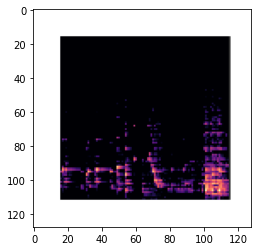

6


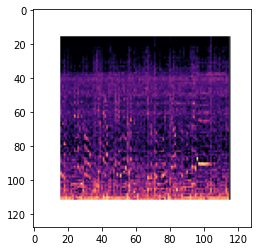

0


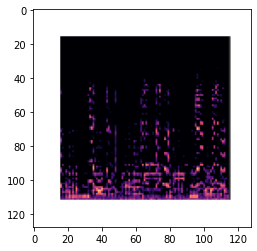

9


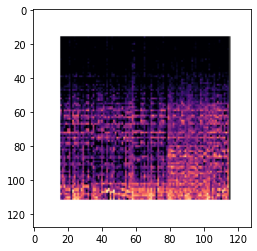

9


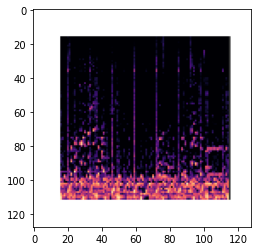

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for _ in range(5):
    img, label = train_dataset.next()
    print(np.argmax(label[0]))
    plt.imshow(img[0])
    plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(128,128,3)))
model.add(MaxPooling2D())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(MaxPooling2D())
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(MaxPooling2D())
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
activation_35 (Activation)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 63, 63, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
activation_36 (Activation)   (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 31, 31, 64)       

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', 
                     metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta = 0.001, patience = 8)
model.fit_generator(train_dataset,
  steps_per_epoch = train_dataset.samples // 64,
  validation_data = val_dataset, 
  validation_steps = val_dataset.samples // 64,
  epochs = 50,
  callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1963: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 4s 270ms/step - loss: 2.3279 - accuracy: 0.1223 - val_loss: 2.2678 - val_accuracy: 0.1927
Epoch 2/50
12/12 [==============================] - 3s 273ms/step - loss: 2.2153 - accuracy: 0.2038 - val_loss: 2.0715 - val_accuracy: 0.2083
Epoch 3/50
12/12 [==============================] - 3s 271ms/step - loss: 2.0612 - accuracy: 0.2554 - val_loss: 2.0033 - val_accuracy: 0.1979
Epoch 4/50
12/12 [==============================] - 3s 280ms/step - loss: 1.9661 - accuracy: 0.2962 - val_loss: 1.8510 - val_accuracy: 0.3542
Epoch 5/50
12/12 [==============================] - 3s 271ms/step - loss: 1.7971 - accuracy: 0.3370 - val_loss: 1.7553 - val_accuracy: 0.3594
Epoch 6/50
12/12 [==============================] - 3s 271ms/step - loss: 1.6376 - accuracy: 0.4443 - val_loss: 1.7371 - val_accuracy: 0.4115
Epoch 7/50
12/12 [==============================] - 3s 276ms/step - loss: 1.4972 - accuracy: 0.4606 - val_loss: 1.8014 - val_accuracy: 0.3802
Epoch 